In [56]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/dnd-parsed-json/mechanics.json
/kaggle/input/dnd-parsed-json/bestiary_noconcat.json
/kaggle/input/dnd-parsed-json/basics.json
/kaggle/input/dnd-parsed-json/items.json
/kaggle/input/dnd-parsed-json/spells_new.json
/kaggle/input/dnd-parsed-json/bestiary.json


# Util-функции

In [57]:
!pip install langchain_experimental
!pip install langchain_huggingface
!pip install langchain_core

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [58]:
import pandas as pd
from langchain_experimental.text_splitter import SemanticChunker
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_core.documents import Document
from typing import List, Dict
import json
from tqdm import tqdm
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)
model_params={"device":device}
embed_fun = HuggingFaceEmbeddings(model_name="cointegrated/rubert-tiny2", model_kwargs = model_params)
def create_splits(doc, embed_fun = embed_fun) -> List:

    text_splitter = SemanticChunker(embed_fun, breakpoint_threshold_type="standard_deviation")



    chunks = text_splitter.split_text(doc)
    embeddings = embed_fun.embed_documents(chunks)

    return chunks, embeddings

cuda


# Правила

In [4]:
df_mech = pd.read_json("/kaggle/input/dnd-parsed-json/mechanics.json")
df_mech = df_mech.drop("fragments",axis=1)

In [5]:

import re


def extract_sources_section(text):
    # Possible starting symbols
    start_symbols = ["\nИсточник:", "\nИсточники:"]
    
    start_index = -1
    for symbol in start_symbols:
        start_index = text.find(symbol)
        if start_index != -1:  
            start_symbol = symbol
            break
    
    if start_index == -1:
        return [] 

    start_index += len(start_symbol)

    end_index = text.find("\n", start_index)
    if end_index == -1:
        end_index = len(text)  
    
    # Extract the sources and split into a list
    sources = text[start_index:end_index].strip()
    return [source.strip() for source in sources.split(",")]

def delete_sources_section(text):
    # Possible starting symbols
    start_symbols = ["\nИсточник:", "\nИсточники:"]
    
    start_index = -1
    for symbol in start_symbols:
        start_index = text.find(symbol)
        if start_index != -1:  
            start_symbol = symbol
            break
    
    if start_index == -1:
        return text  
    
 
    start_index += len(start_symbol)

    end_index = text.find("\n", start_index)
    if end_index == -1:
        end_index = len(text)  
    

    updated_text = text[:text.find(start_symbol)] + text[end_index:]
    return updated_text.strip()


def clean_desc(string):
    return string.replace("\n", " ")

df_mech["source"] = df_mech["description"].apply(lambda x: extract_sources_section(x))
df_mech["description"] = df_mech["description"].apply(lambda x: delete_sources_section(x))
df_mech["description"] = df_mech["description"].apply(lambda x: clean_desc(x))


In [6]:
df_basics = pd.read_json("/kaggle/input/dnd-parsed-json/basics.json")

In [7]:
def extract_sources_section(text):

    start_symbols = ["**Источник:**"]
    
    start_index = -1
    for symbol in start_symbols:
        start_index = text.find(symbol)
        if start_index != -1:  
            start_symbol = symbol
            break
    
    if start_index == -1:
        return None  

    start_index += len(start_symbol)
    end_index = text.find("\n", start_index)
    if end_index == -1:
        end_index = len(text)  
    
    sources = text[start_index:end_index].strip()
    return [source.strip() for source in sources.split(",")]

def delete_sources_section(text):
    # Possible starting symbols
    start_symbols = ["**Источник:**"]
    
    start_index = -1
    for symbol in start_symbols:
        start_index = text.find(symbol)
        if start_index != -1:  
            start_symbol = symbol
            break
    
    if start_index == -1:
        return text 
    
    start_index += len(start_symbol)

    end_index = text.find("\n", start_index)
    if end_index == -1:
        end_index = len(text)  
    
    updated_text = text[:text.find(start_symbol)] + text[end_index:]
    return updated_text.strip()

def clean_desc(string):
    return string.replace("*","").replace("\n","")

In [8]:
df_basics["source"] = df_basics["description"].apply(lambda x : extract_sources_section(x))
df_basics["description"] = df_basics["description"].apply(lambda x : delete_sources_section(x))
df_basics["description"] = df_basics["description"].apply(lambda x : clean_desc(x))

In [9]:
df_rules = pd.concat([df_basics,df_mech], axis=0)

In [10]:

df_rules["source"]= df_rules["source"].fillna("Player's handbook")

In [13]:
%%time
df_rules['chunks'],df_rules["embeddings"] = zip(*df_rules['description'].map(lambda x: create_splits(x)))

chunked_df = df_rules.explode(['chunks',"embeddings"]).reset_index(drop=True)


                             name  \
0    Использование характеристик    
1    Использование характеристик    
2               Основные формулы    
3       Часто задаваемые вопросы    
4        Как начать играть в D&D    
..                            ...   
103          Скакуны и транспорт    
104          Скакуны и транспорт    
105       Сложность боевой сцены    
106       Сложность боевой сцены    
107             Смешивание зелий    

                                           description  \
0     Физические и умственные способности любого су...   
1     Физические и умственные способности любого су...   
2     Модификатор характеристики: (Значение характе...   
3        Заклинания бонусным действием и ограничени...   
4       Введение   Процесс игры   Броски костей   П...   
..                                                 ...   
103  СкакуныТранспортПримеры кораблейОфицеры и экип...   
104  СкакуныТранспортПримеры кораблейОфицеры и экип...   
105  При создании боевой сцены от

In [19]:
chunked_df.to_csv("/kaggle/working/rules.csv",index=False)

**EDA**

*Количество чанков*

In [18]:
chunked_df.groupby("name")["chunks"].count()

name
Безумие                                  1
Бестиарий                                4
Благоволение                             1
Болезни                                  1
Вдохновение                              1
Дары всех мастей                         8
Действия                                 4
Деятельность во время простоя           12
Еда, напитки и постой                    2
Использование заклинаний                 5
Использование характеристик              2
Как начать играть в D&D                  2
Ловушки                                  9
Мультиклассирование                      1
Напарники                                1
Окружающая среда и укрытия              10
Основные формулы                         1
Перемещения и позиция в бою              3
Персонализация вашего происхождения      1
Покровители группы                       3
Помните 10 правил                        1
Происхождения                            1
Развитие Отголосков Дивергенции          1
Сборни

*среднее количество предложений в чанке*

In [31]:
def count_sentences(text):
    return len([s for s in text.split('.') if s.strip()])

chunked_df["sentence_count"] = chunked_df["chunks"].apply(lambda x: count_sentences(x))
chunked_df[["name","sentence_count"]].groupby("name").mean()

,sentence_count
name,
Безумие,49.000000
Бестиарий,58.500000
Благоволение,30.000000
Болезни,82.000000
Вдохновение,93.000000
Дары всех мастей,129.500000
Действия,47.250000
Деятельность во время простоя,58.416667
"Еда, напитки и постой",55.500000


*****Анализ корпуса*****

In [45]:
!pip install pymorphy2

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 62.2 MB/s eta 0:00:0000:0100:01


In [56]:
%%time
from nltk.corpus import stopwords
import re
import pymorphy2


morph = pymorphy2.MorphAnalyzer()

def clean(review):
    review = review.lower()  

    review = re.sub('[^а-яА-Яa-zA-Z0-9\s.,!?-]+', '', review)

    words = review.split()
    cleaned_words = [
        morph.parse(word)[0].normal_form
        for word in words
        if not word.isdigit() and word not in stopwords.words('russian')
    ]

    review = " ".join(cleaned_words)
    return review

chunked_corp = chunked_df.copy()
chunked_corp["chunks"] = chunked_df["chunks"].apply(lambda x: clean(x))


CPU times: user 30.9 s, sys: 3.02 s, total: 33.9 s
Wall time: 33.9 s


In [57]:
def corpus(text):
    text_list = text.split()
    return text_list
chunked_corp["chunks"] = chunked_corp["chunks"].apply(corpus)

In [58]:
chunked_corp

,name,description,source,chunks,embeddings,sentence_count
0,Использование характеристик,Физические и умственные способности любого су...,[«Player's handbook»],"[физический, умственный, способность, любой, с...","[0.019604075700044632, -0.022656399756669998, ...",15
1,Использование характеристик,Физические и умственные способности любого су...,[«Player's handbook»],"[использовать, больший, результат,ести, преиму...","[0.009732558391988277, -0.006384447682648897, ...",242
2,Основные формулы,Модификатор характеристики: (Значение характе...,[«Player's handbook»],"[модификатор, характеристика, значение, характ...","[-0.030211353674530983, -0.019164040684700012,...",3
3,Часто задаваемые вопросы,Заклинания бонусным действием и ограничени...,[«Player's handbook»],"[заклинание, бонусный, действие, ограничение, ...","[-0.00932577345520258, -0.001869608648121357, ...",73
4,Как начать играть в D&D,Введение Процесс игры Броски костей П...,Player's handbook,"[введение, процесс, игра, бросок, кость, поиск...","[0.031437233090400696, 0.01752348802983761, -0...",111
...,...,...,...,...,...,...
103,Скакуны и транспорт,СкакуныТранспортПримеры кораблейОфицеры и экип...,"[Player's handbook, Tomb of Annihilation, Bald...","[попадание, 5к10, дробящий, урона., сорокопут,...","[0.0026575163938105106, 0.01989690400660038, -...",37
104,Скакуны и транспорт,СкакуныТранспортПримеры кораблейОфицеры и экип...,"[Player's handbook, Tomb of Annihilation, Bald...","[попадание, 5к10, дробящий, урона., тиран, бех...","[0.029638564214110374, -0.009167659096419811, ...",31
105,Сложность боевой сцены,При создании боевой сцены отпустите своё вообр...,[Dungeon master's guide],"[создание, боевой, сцена, отпустить, сво, вооб...","[0.01977425627410412, -0.012496469542384148, -...",41
106,Сложность боевой сцены,При создании боевой сцены отпустите своё вообр...,[Dungeon master's guide],"[стоить, учитывать, вносить, действительно, ве...","[0.0390523299574852, -0.05141398310661316, -0....",34


In [61]:
from tqdm import trange
corpus = []
for i in trange(chunked_df.shape[0], ncols=150, nrows=10, colour='green', smoothing=0.8):
    corpus += chunked_corp['chunks'][i]
len(corpus)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 108/108 [00:00<00:00, 42181.29it/s]


93167

In [66]:
import seaborn as sns
import matplotlib.pyplot as plt

In [69]:
from collections import Counter
mostCommon = Counter(corpus).most_common(20)
mostCommon

[('который', 960),
 ('мочь', 916),
 ('заклинание', 809),
 ('существо', 805),
 ('ваш', 730),
 ('персонаж', 628),
 ('использовать', 616),
 ('это', 576),
 ('один', 551),
 ('проверка', 478),
 ('свой', 465),
 ('атака', 447),
 ('действие', 422),
 ('каждый', 421),
 ('получать', 418),
 ('урон', 404),
 ('должный', 400),
 ('другой', 391),
 ('магический', 337),
 ('такой', 322)]

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


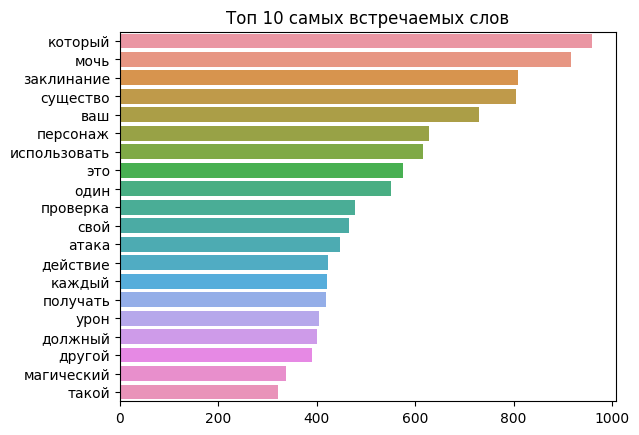

In [70]:
words = []
freq = []
for word, count in mostCommon:
    words.append(word)
    freq.append(count)
sns.barplot(x=freq, y=words)
plt.title('Топ 10 самых встречаемых слов')
plt.show()

# Бестиарий


In [59]:
import json
with open('/kaggle/input/dnd-parsed-json/bestiary_noconcat.json') as f:
    data = json.load(f)

In [60]:
df_bestiary = pd.json_normalize(data,max_level=1)
df_bestiary.columns = [col.split('.')[-1] for col in df_bestiary.columns]
df_bestiary.columns 
df_bestiary = df_bestiary.drop(["Языки:",""],axis=1)

In [61]:
df_bestiary["search_desc"] = df_bestiary["Name"]+" "+df_bestiary["Description"].fillna("")+" "+df_bestiary["Иммунитет к урону"].fillna("")+" "+\
df_bestiary["Уязвимость к урону"].fillna("")

In [62]:
df_bestiary["Бонус мастерства"] = df_bestiary["Бонус мастерства"].astype(str)

In [63]:
cols_fill=["Спасброски","Уязвимость к урону","Иммунитет к урону","Навыки","Description","Source","Языки","Чувства"]
df_bestiary[cols_fill] =df_bestiary[cols_fill].fillna("")

In [64]:
cols_fill=["Скорость","Опасность"]
df_bestiary[cols_fill] =df_bestiary[cols_fill].fillna(0)

In [65]:
df_bestiary[["Abilities","Actions"]] =df_bestiary[["Abilities","Actions"]].fillna("").apply(list)

In [66]:
df_bestiary = df_bestiary[~(df_bestiary["Name"]=="Комментарии")]

In [67]:
df_bestiary.shape

(2859, 17)

In [68]:
%%time
df_bestiary['chunks'],df_bestiary["embeddings"] = zip(*df_bestiary['search_desc'].map(lambda x: create_splits(x)))
chunked_df1 = df_bestiary.explode(['chunks',"embeddings"]).reset_index(drop=True)


CPU times: user 36.3 s, sys: 1.25 s, total: 37.6 s
Wall time: 30.5 s


In [77]:
chunked_df1 = chunked_df1.rename(columns = {"Класс Доспеха":"Armor_Class", "Хиты": "HP", "Скорость":"Speed","Навыки":"Skills","Иммунитет к урону": "Damage_Immunity",
                                           "Чувства":"Senses","Языки":"Languages","Опасность": "Challenge_rating","Бонус мастерства":" Proficiency_Bonus","Уязвимость к урону":"Damage_Vulnerability",
                                           "Спасброски": "Saving_throws"})

In [78]:
chunked_df1

,Name,Source,Abilities,Actions,Description,Armor_Class,HP,Speed,Skills,Damage_Immunity,Senses,Languages,Challenge_rating,Proficiency_Bonus,Saving_throws,Damage_Vulnerability,search_desc,chunks,embeddings
0,Гиносфинкс [Gynosphinx],«Monster manual»,[Непостижимый. Сфинкс обладает иммунитетом ко ...,[Мультиатака.Сфинкс совершает две атаки когтем...,Тело гиносфинкса венчает голова гуманоидной же...,17 (природный доспех),136(16к10+48),"40 футов, летая60 футов","Восприятие+8,История+12,Магия+12,Религия+8",психическая энергия,"истинное зрение?120 футов, пассивное Восприятие18","Общий, Язык Сфинксов",11 (7200 опыта),+4,,,Гиносфинкс [Gynosphinx] Тело гиносфинкса венча...,Гиносфинкс [Gynosphinx] Тело гиносфинкса венча...,"[0.05596435070037842, 0.0085481321439147, 0.02..."
1,Фляга Вина [Flask of Wine],«Tomb of Annihilation»,[Языки. Фляга знает Общий плюс два других язык...,[Мультиатака. Фляга совершает две атаки когтям...,Туманная Река [River Mist]и Фляга Вина – сестр...,14 (кожаный доспех),40(9к8),"30 футов, лазая20 футов","Атлетика+2,Восприятие+4,Выживание+6,Скрытность+5",,"тёмное зрение?60 футов, пассивное Восприятие14",. Фляга знает Общий плюс два других языка.Коша...,1 (200 опыта),+2,,,Фляга Вина [Flask of Wine] Туманная Река [Rive...,Фляга Вина [Flask of Wine] Туманная Река [Rive...,"[0.0543910376727581, 0.025463853031396866, -0...."
2,Громила звёздных порождений [Star Spawn Hulk],«Mordenkainen's Tome of Foes»,[Психическое отражение. Если громила получает ...,[Мультиатака.Громила совершает две атаки Разма...,“Не звёзды породили этих созданий.Незачем обви...,16 (природный доспех),136(13к10+65),30 футов,Восприятие+5,,"тёмное зрение?60 футов, пассивное Восприятие15",Глубинная речь,10 (5900 опыта),+4,"Лов+3, Мдр+5",,Громила звёздных порождений [Star Spawn Hulk] ...,Громила звёздных порождений [Star Spawn Hulk] ...,"[0.05171207711100578, 0.01841217838227749, 0.0..."
3,Дитя лавы [Lava child],«Waterdeep: Dungeon of the Mad Mage»,[Иммунитет к металлу.Дитя лавы может беспрепят...,[Мультиатака.Дитя лавы совершает две атаки: од...,"Физически похожие друг на друга, дети лавы име...",11,60(8к8+24),"25 футов, лазая20 футов","Атлетика+6,Выживание+2","огонь; дробящий, колющий, рубящий от оружия из...","тёмное зрение?60 футов, пассивное Восприятие10","Общий, Игнан",3 (700 опыта),+2,,,Дитя лавы [Lava child] Физически похожие друг ...,Дитя лавы [Lava child] Физически похожие друг ...,"[0.12214183062314987, -0.013080200180411339, 0..."
4,Гриз Алакритос [Gryz Alakritos],«Critical Role: Call of the Netherdeep»,[Языки. Знает Общий и ещё три языка.Ловкий поб...,[Мультиатака. Гриз совершает две атаки Разрядо...,Учёные-манипуляторы - это грозные лидеры акаде...,12 (15 с доспехом мага),82(15к8+15),30 футов,"Восприятие+6,История+7,Магия+7,Проницательность+6",,"тёмное зрение?60 футов, пассивное Восприятие16",. Знает Общий и ещё три языка.Ловкий побег.Гри...,5 (1800 опыта),+3,"Инт+7, Мдр+6",,Гриз Алакритос [Gryz Alakritos] Учёные-манипул...,Гриз Алакритос [Gryz Alakritos] Учёные-манипул...,"[0.046435270458459854, 0.006077085621654987, -..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2871,Гигантская улитка [Giant Snail],«The Wild Beyond The Witchlight: A Feywild Adv...,[Чувствительность к соли. Если улитка начинает...,[Размашистый удар. Рукопашная атака оружием:+4...,Эти большие моллюски при испуге прячутся в сво...,11 (природный доспех),22(4к10),"10 футов, лазая10 футов",,,"тёмное зрение?60 футов, пассивное Восприятие10",,1/4 (50 опыта),+2,,,Гигантская улитка [Giant Snail] Эти большие мо...,Гигантская улитка [Giant Snail] Эти большие мо...,"[0.036502107977867126, -0.004150770138949156, ..."
2872,Эттеркап [Ettercap],«Monster manual»,[Паучье лазание. Эттеркап может лазать по слож...,[Мультиатака.Эттеркап совершает две атаки: одн...,"Эттеркапы похожи на человекоподобных пауков, к...",13 (природный доспех),44(8к8+8),"30 футов, лазая30 футов","Восприятие+3,Выживание+3,Скрытность+4",,"тёмное зрение?60 футов, пассивное Восприятие13"

In [79]:
chunked_df1.to_csv("bestiary.csv",index=False)

**EDA**

In [15]:
s = chunked_df1.groupby("Name")["chunks"].count().reset_index()
s[s["chunks"]!=1]
#Возможно чанкинг не сильно то и нужен

,Name,chunks
25,Айзек Стражни [Izek Strazni],2
62,Амфисбена [Amphisbaena],2
153,Бафомет [Baphomet],2
181,Бессмертный советник [Undying Councilor],2
204,Боец [Warrior],2
210,Большой мимик [Large Mimic],2
319,Верворон [Wereraven],2
368,Взрослый солнечный дракон [Adult Solar Dragon],2
407,Вирмлинг солнечного дракона [Solar Dragon Wyrm...,2
412,Владимир Хорнгаард [Vladimir Horngaard],2


In [16]:
def count_sentences(text):
    return len([s for s in text.split('.') if s.strip()])

chunked_df1["sentence_count"] = chunked_df1["chunks"].apply(lambda x: count_sentences(x))
chunked_df1[["Name","sentence_count"]].groupby("Name").mean()

,sentence_count
Name,
«Демогоргон» [«The Demogorgon»],7.0
Аазон Талиери [Aazon Talieri],1.0
Ааракокра [Aarakocra],18.0
Ааракокра рулевой [Aarakocra Spelljammer],1.0
Ааракокра симулякр [Aarakocra Simulacrum],18.0
...,...
Ясновидящий свежеватель разума [Mind Flayer Clairvoyant],6.0
Ястреб [Hawk],1.0
Ястреб разорителей [Harrow Hawk],7.0


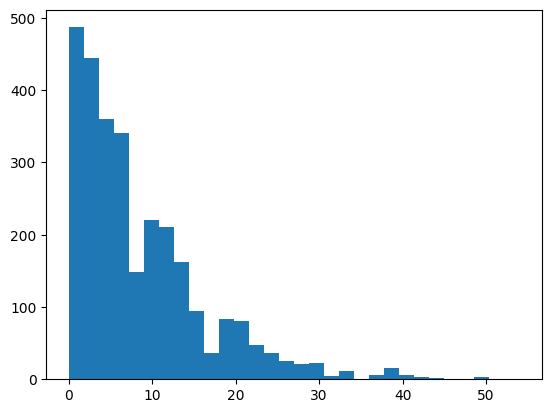

In [22]:
import matplotlib.pyplot as plt
plt.hist(chunked_df1["sentence_count"],bins= 30)
plt.show()

Cреднее количество абилок и действий

In [28]:
print(df_bestiary["Abilities"].apply(len).mean())
print(df_bestiary["Actions"].apply(len).mean())
#Если что-то из этого пойдет внезапно вверх при добавлении - можно проверить на дубликаты

3.3382301504022385
0.9874081846799581


Количество пустых(не пропущенных)

In [29]:
def count_empty_lines(column):
    return column.apply(lambda x: x == "" or x == []).sum()


empty_counts = df_bestiary.apply(count_empty_lines)


print(empty_counts)

Name                     0
Source                   0
Abilities               61
Actions                 36
Description            402
Класс Доспеха            0
Хиты                     0
Скорость                 0
Навыки                 864
Иммунитет к урону     1895
Чувства                 24
Языки                  588
Опасность               39
Бонус мастерства         0
Спасброски            1629
Уязвимость к урону    2756
search_desc              0
chunks                   0
embeddings               0
dtype: int64


# Спеллы

In [92]:
df_spells = pd.read_json("/kaggle/input/dnd-parsed-json/spells_new.json")

In [93]:
df_spells 

,title,title_sort,title_en,link,level,school,item_prefix,item_prefix_title,item_tags,item_suffix,...,filter_source,filter_school,filter_concentration,filter_ritual,filter_components,filter_casttime,filter_damtype,filter,description,name
0,Адское возмездие,АДСКОЕ ВОЗМЕЗДИЕ,Hellish rebuke,/spells/1-hellish-rebuke/,1,Воплощение,1,1 уровень,[],ВС.,...,[102],[1],[1],[1],1|1|0|,[reaction],[13],[],"1 уровень, воплощение\nВремя накладывания: 1 р...",Адское возмездие
1,Антипатия/симпатия,АНТИПАТИЯ/СИМПАТИЯ,Antipathy/sympathy,/spells/2-antipathysympathy/,8,Очарование,8,8 уровень,[],ВСМ,...,[102],[6],[1],[1],1|1|1|,[hour],[],[],"8 уровень, очарование\nВремя накладывания: 1 ч...",Антипатия/симпатия
2,Аура живучести,АУРА ЖИВУЧЕСТИ,Aura of vitality,/spells/3-aura-of-vitality/,3,Воплощение,3,3 уровень,"{'concentration': {'tag_value': 'К', 'tag_titl...",В..,...,[102],[1],[2],[1],1|0|0|,[action],[],[],"3 уровень, воплощение\nВремя накладывания: 1 д...",Аура живучести
3,Аура жизни,АУРА ЖИЗНИ,Aura of life,/spells/4-aura-of-life/,4,Ограждение,4,4 уровень,"{'concentration': {'tag_value': 'К', 'tag_titl...",В..,...,[102],[5],[2],[1],1|0|0|,[action],[],[],"4 уровень, ограждение\nВремя накладывания: 1 д...",Аура жизни
4,Аура очищения,АУРА ОЧИЩЕНИЯ,Aura of purity,/spells/5-aura-of-purity/,4,Ограждение,4,4 уровень,"{'concentration': {'tag_value': 'К', 'tag_titl...",В..,...,[102],[5],[2],[1],1|0|0|,[action],[],[],"4 уровень, ограждение\nВремя накладывания: 1 д...",Аура очищения
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
519,Разбрасывание карт,РАЗБРАСЫВАНИЕ КАРТ,Spray of Cards,/spells/4664-spray-of-cards/,2,Вызов,2,2 уровень,[],ВСМ,...,[207],[2],[1],[1],1|1|1|,[action],[20],[],"2 уровень, вызов\nВремя накладывания: 1 действ...",Разбрасывание карт
520,Воздушный пузырь,ВОЗДУШНЫЙ ПУЗЫРЬ,Air bubble,/spells/4760-air-bubble/,2,Вызов,2,2 уровень,[],.С.,...,[160],[2],[1],[1],0|1|0|,[action],[],[],"2 уровень, вызов\nВремя накладывания: 1 действ...",Воздушный пузырь
521,Сотворение магического руля,СОТВОРЕНИЕ МАГИЧЕСКОГО РУЛЯ,Creating spelljamming helm,/spells/4761-creating-spelljamming-helm/,5,Преобразование,5,5 уровень,[],ВСМ,...,[160],[7],[1],[1],1|1|1|,[action],[],[],"5 уровень, преобразование\nВремя накладывания:...",Сотворение магического руля
522,Запечатывание врат,ЗАПЕЧАТЫВАНИЕ ВРАТ,Gate seal,/spells/6578-gate-seal/,4,Ограждение,4,4 уровень,[],ВСМ,...,[205],[5],[1],[1],1|1|1|,[minute],[],[],"4 уровень, ограждение\nВремя накладывания: 1 м...",Запечатывание врат


In [95]:
df_spells.columns

Index(['title', 'title_sort', 'title_en', 'link', 'level', 'school',
       'item_prefix', 'item_prefix_title', 'item_tags', 'item_suffix',
       'item_icon', 'item_icon_title', 'filter_text', 'filter_level',
       'filter_class', 'filter_class_tce', 'filter_archetype', 'filter_source',
       'filter_school', 'filter_concentration', 'filter_ritual',
       'filter_components', 'filter_casttime', 'filter_damtype', 'filter',
       'description', 'name'],
      dtype='object')

In [96]:
to_remove = ['title_sort','item_prefix', 'item_prefix_title','item_tags','item_suffix','item_icon','item_icon_title','filter_text',
'filter_level',
       'filter_class', 'filter_class_tce', 'filter_archetype', 'filter_source',
       'filter_school', 'filter_concentration', 'filter_ritual',
       'filter_components', 'filter_casttime', 'filter_damtype', 'filter',"name"]

In [97]:
df_spells =df_spells.drop(to_remove,axis=1)

In [100]:
def extract_spell_details(spell_text):

    patterns = {
        "cast": r"Время накладывания:\s*([^\n]+)",
        "dist": r"Дистанция:\s*([^\n]+)",
        "comp": r"Компоненты:\s*([^\n]+)",
        "duration": r"Длительность:\s*([^\n]+)",
        "classes": r"Классы:\s*([^\n]+)",
        "source": r"Источник:\s*([^\n]+)"
    }

    extracted_data = {key: None for key in patterns.keys()}

    for key, pattern in patterns.items():
        match = re.search(pattern, spell_text)
        if match:
            extracted_data[key] = match.group(1).strip()

    description_start = re.search(r"Источник:\s*[^\n]+", spell_text)
    if description_start:
        start_index = description_start.end()
        description = spell_text[start_index:].strip()
        extracted_data["desc"] = description
    else:
        extracted_data["desc"] = None

    return tuple(extracted_data.values())  

def parse_spells(df):
    try:
        result = df["description"].apply(extract_spell_details)
        df[["cast", "dist", "comp", "duration", "classes", "source", "desc"]] = pd.DataFrame(result.tolist(), columns=["cast", "dist", "comp", "duration", "classes", "source", "desc"])
        return df
    except Exception as e:
        print("Error during processing:", str(e))
        return df

df_spells= parse_spells(df_spells)



In [104]:
df_spells=df_spells.fillna("")

In [105]:
df_spells=df_spells.drop("description",axis=1)

In [106]:
def clean_level(string):
    if string == "Заговор":
        return 0
    else:
        return int(string)
df_spells["level"]= df_spells["level"].apply(lambda x: clean_level(x))


In [107]:
%%time
df_spells["embeddings"] = df_spells["desc"].apply(lambda x : embed_fun.embed_documents(x))

CPU times: user 6min 14s, sys: 13.6 s, total: 6min 28s
Wall time: 6min 16s


In [110]:
df_spells.to_csv("/kaggle/working/spells.csv")

*****EDA*****

*Количество спеллов по школам заклианий*

In [119]:
import matplotlib.pyplot as plt

<BarContainer object of 8 artists>

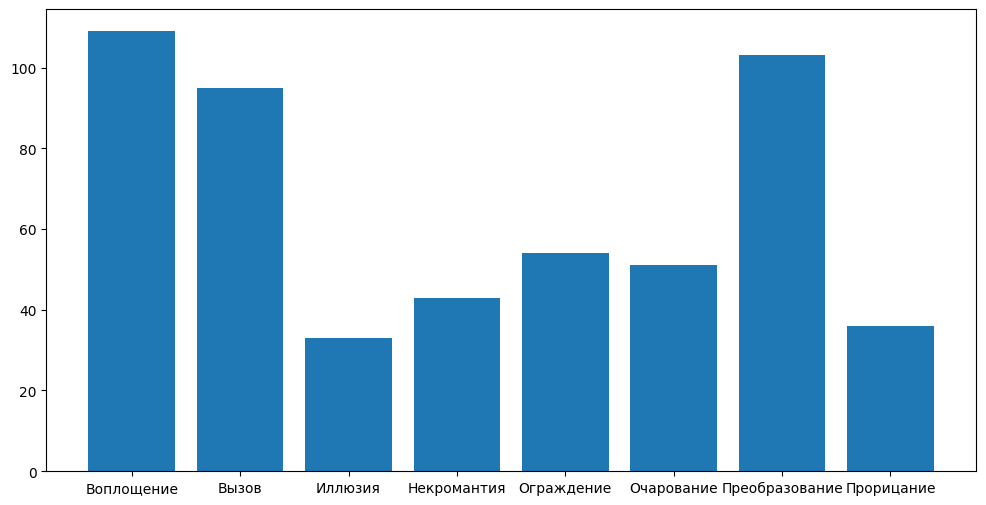

In [121]:
df_schools = df_spells[["title","school"]].groupby("school").count().reset_index()
plt.subplots(figsize =(12,6))
plt.bar(df_schools["school"],df_schools["title"])
plt.show()

Распределение по уровням

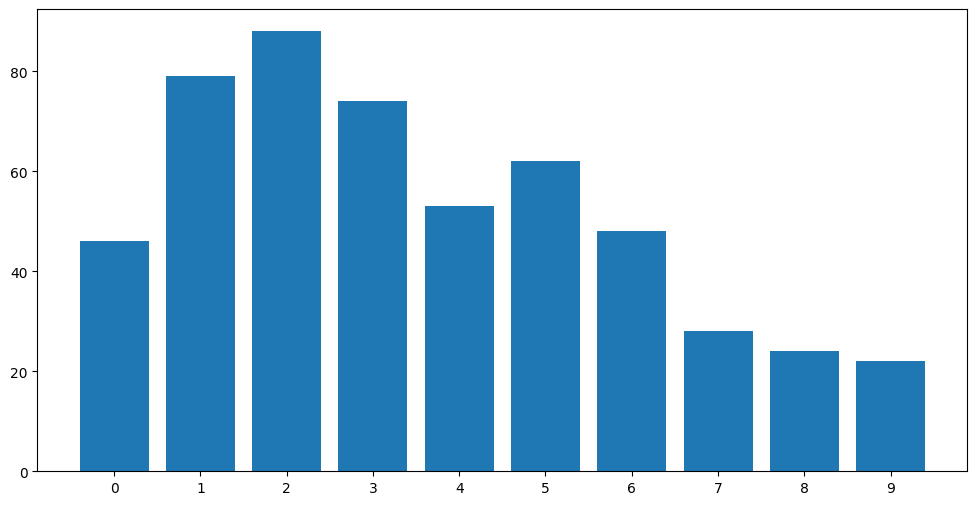

In [126]:
df_schools = df_spells[["title","level"]].groupby("level").count().reset_index()
plt.subplots(figsize =(12,6))
plt.bar(df_schools["level"],df_schools["title"])
plt.xticks(range(0,10))
plt.show()

Классы

In [139]:
import seaborn as sns
import matplotlib.pyplot as plt


df_spells_eda = df_spells.copy()

df_spells_eda ['classes'] =df_spells_eda ['classes'].str.split(',') 

df_spells_eda['classes'] = df_spells_eda ['classes'].apply(lambda x: [cls.strip() for cls in x])

df_expanded = df_spells_eda [["title", "classes"]].explode('classes')


spell_count = df_expanded['classes'].value_counts().reset_index()
spell_count.columns = ['classes', 'count']

spell_count

,classes,count
0,волшебник,345
1,чародей,224
2,друид,168
3,бард,158
4,колдун,141
5,жрец,125
6,изобретатель,100
7,следопыт,70
8,паладин,53
9,,18


Пустая строка - заклианния только у подклассов

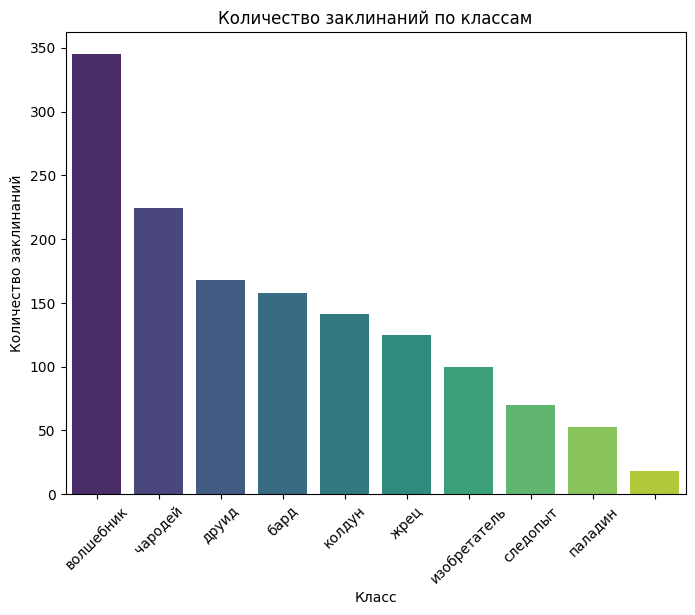

In [149]:

plt.figure(figsize=(8, 6))
sns.barplot(x='classes', y='count', data=spell_count, palette='viridis')
plt.title('Количество заклинаний по классам')
plt.xlabel('Класс')
plt.ylabel('Количество заклинаний')
plt.xticks(rotation=45)  
plt.show()

# итемы

In [16]:
df_items = pd.read_json("/kaggle/input/dnd-parsed-json/items.json")

In [17]:

def clean_name(string):
    string = string.replace("\n", "").replace("\t", "").replace("\r", "").replace("Магические предметы","")
    return string
def clean_cost(string):
    if isinstance(string,str):
        string = string.replace(":", "").replace(" ", "")
        
        return string
    else: return None

def clean_description(string):

    string = " ".join(string)
    return string



df_items["name"] = df_items["name"].apply(lambda x: clean_name(x))
df_items["cost"] = df_items["cost"].apply(lambda x: clean_cost(x))
df_items["description"] = df_items["description"].apply(lambda x: clean_description(x))

In [18]:
import re

def cost_to_list(value):
    if value is None:  
        return None
    

    match = re.match(r"(\d+)-(\d+)", value)
    if match:
        start, end = map(int, match.groups())
        return [start, end]
    return None  # Return None for invalid formats

In [19]:
df_items["cost"] = df_items["cost"].apply(cost_to_list)

In [20]:
df_items


,name,cost,type,description
0,Абракадабрус,"[5001, 50000]","Чудесный предмет, очень редкий","Абракадабрус-это богато украшенный, усыпанный ..."
1,Адамантиновый доспех,"[101, 500]","Доспех (средний или тяжёлый, кроме шкурного), ...","Эти доспехи усилены адамантином, одним из самы..."
2,Адская машина Лума Безумного,None,"Чудесный предмет, артефакт (требуется настройка)","Когда-то считалось, что это странное устройств..."
3,Адское оружие,"[101, 500]","Оружие (любое), необычное",Это оружие выковано из адского железа и прониз...
4,"Акмон, молот Пирфора",None,"Оружие (боевой молот), артефакт (требуется нас...","Молот Пирфора творит чудеса и бедствия, бог ку..."
...,...,...,...,...
929,Эмблема Когтей,"[101, 500]","Чудесный предмет, необычный",Самоцветы на эмблеме Культа Дракона загораются...
930,Эмблема стража,"[101, 500]","Чудесный предмет (священный символ), необычный...",Эта эмблема является символом божества или дух...
931,"Эфиксида, лук Нилеи",None,"Оружие (короткий лук), артефакт (требуется нас...","Нилея владеет коротким луком Эфиксидой, чьи ст..."
932,Язык пламени,"[501, 5000]","Оружие (любой меч), редкое (требуется настройка)",Вы можете бонусным действием произнести команд...


In [21]:
df_items.isnull().any()

name           False
cost            True
type            True
description    False
dtype: bool

In [22]:
df_items["cost"] = df_items["cost"].fillna("").apply(list)

In [24]:
df_items

,name,cost,type,description
0,Абракадабрус,"[5001, 50000]","Чудесный предмет, очень редкий","Абракадабрус-это богато украшенный, усыпанный ..."
1,Адамантиновый доспех,"[101, 500]","Доспех (средний или тяжёлый, кроме шкурного), ...","Эти доспехи усилены адамантином, одним из самы..."
2,Адская машина Лума Безумного,[],"Чудесный предмет, артефакт (требуется настройка)","Когда-то считалось, что это странное устройств..."
3,Адское оружие,"[101, 500]","Оружие (любое), необычное",Это оружие выковано из адского железа и прониз...
4,"Акмон, молот Пирфора",[],"Оружие (боевой молот), артефакт (требуется нас...","Молот Пирфора творит чудеса и бедствия, бог ку..."
...,...,...,...,...
929,Эмблема Когтей,"[101, 500]","Чудесный предмет, необычный",Самоцветы на эмблеме Культа Дракона загораются...
930,Эмблема стража,"[101, 500]","Чудесный предмет (священный символ), необычный...",Эта эмблема является символом божества или дух...
931,"Эфиксида, лук Нилеи",[],"Оружие (короткий лук), артефакт (требуется нас...","Нилея владеет коротким луком Эфиксидой, чьи ст..."
932,Язык пламени,"[501, 5000]","Оружие (любой меч), редкое (требуется настройка)",Вы можете бонусным действием произнести команд...


In [25]:
%%time
df_items['chunks'],df_items["embeddings"] = zip(*df_items['description'].map(lambda x: create_splits(x)))
chunked_df2= df_items.explode(['chunks',"embeddings"]).reset_index(drop=True)


CPU times: user 2min 16s, sys: 660 ms, total: 2min 16s
Wall time: 2min 14s


In [23]:
chunked_df2.to_csv("/kaggle/working/items.csv",index=False)

NameError: name 'chunked_df2' is not defined

In [32]:
t = chunked_df2[["name","chunks"]].groupby("name").count()
t[t["chunks"]!=1]
#также вопрос чанкования сомнителен

,chunks
name,
Демономикон Иггвилв,2
Инструмент бардов,2
Камень Йоун,2
Колода многих вещей,2
Кольцо зимы,2
Любина тарокка душ,2
Могучий слуга Леук-о,2
Посох защиты,2
Посох паука,2


In [33]:
def count_sentences(text):
    return len([s for s in text.split('.') if s.strip()])

chunked_df2["sentence_count"] = chunked_df2["chunks"].apply(lambda x: count_sentences(x))
chunked_df2[["name","sentence_count"]].groupby("name").mean()

,sentence_count
name,
Абракадабрус,11.0
Адамантиновый доспех,2.0
Адская машина Лума Безумного,35.0
Адское оружие,2.0
"Акмон, молот Пирфора",25.0
...,...
Эмблема Когтей,3.0
Эмблема стража,5.0
"Эфиксида, лук Нилеи",35.0


In [50]:
import matplotlib.pyplot as plt
def mean_cost(c):
    if len(c)!=0:
        return (c[0]+c[1])/2
    return 0
chunked_df2["mean_cost"] = chunked_df2["cost"].apply(lambda x : mean_cost(x))
cats_cost = chunked_df2[["name","mean_cost"]].groupby("name").mean()
cats_cost["mean_cost"].max()
def groups(c):
    if c>=20000:
        return ">20000"
    elif c >= 10000:
        return ">10000"
    elif c >= 5000:
        return "10000>x>5000"
    elif c>= 1000:
        return "5000>x>1000"
    elif c>= 500:
        return "1000>x>500"
    else: return "<500"

cats_cost["cat"] = cats_cost["mean_cost"].apply(groups)


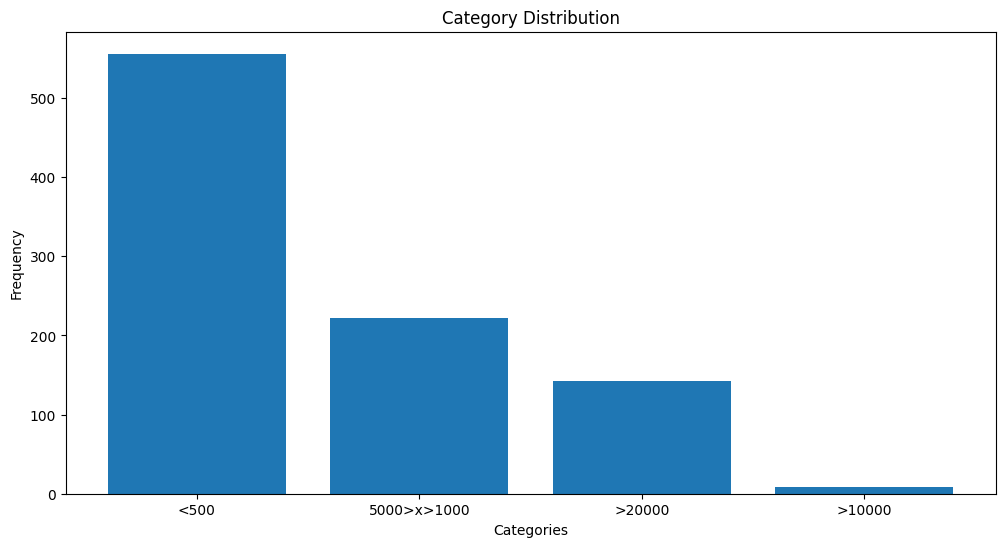

In [67]:
plt.figure(figsize=(12, 6))

cats = cats_cost['cat'].value_counts()  
plt.bar(cats.index, cats.values, align='center')

plt.xlabel('Categories')
plt.ylabel('Frequency')
plt.title('Category Distribution')

plt.show()